In [1]:
import numpy as np
import pandas as pd 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']#设置中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False #正常显示负号
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tabpy_client
client = tabpy_client.Client('http://localhost:9004')

# KMeans建模

## 数据导入与构建新字段

In [2]:
dfpath = 'D:\\dataanalyse\\learning_materials\\大工具课第二期\\自己实操\\项目四天气API数据的自动获取入库与升温城市投放建议算法调用\\天气数据.csv'
weather_=pd.read_csv(dfpath,encoding="gbk")
weather_['明今温差']=weather_.明天high-weather_.当天high
weather_['后今温差'] = weather_.后天high - weather_.当天high
weather_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30129 entries, 0 to 30128
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   行政区属    30129 non-null  object 
 1   城市      30129 non-null  object 
 2   城市ID    30129 non-null  object 
 3   日期      30129 non-null  object 
 4   更新时间    30129 non-null  object 
 5   当天high  30129 non-null  int64  
 6   前天high  29403 non-null  float64
 7   昨天high  29766 non-null  float64
 8   后天high  29403 non-null  float64
 9   明天high  29766 non-null  float64
 10  当天low   30129 non-null  int64  
 11  前天Low   29403 non-null  float64
 12  昨天Low   29766 non-null  float64
 13  后天Low   29403 non-null  float64
 14  明天Low   29766 non-null  float64
 15  明今温差    29766 non-null  float64
 16  后今温差    29403 non-null  float64
dtypes: float64(10), int64(2), object(5)
memory usage: 3.9+ MB


## 数据处理

In [3]:
weather_ = weather_.dropna()#删除空值行，空值小于3%，一般可以考虑直接删除
weather_.reset_index(drop= True,inplace=True)

In [4]:
weather_.head(20)

,行政区属,城市,城市ID,日期,更新时间,当天high,前天high,昨天high,后天high,明天high,当天low,前天Low,昨天Low,后天Low,明天Low,明今温差,后今温差
0,"阿里,阿里,西藏,中国",阿里,TV9JG0M1S9QU,2021-04-23,2021-04-23 00:00:00,3,6.0,5.0,8.0,4.0,-7,-4.0,-9.0,-13.0,-10.0,1.0,5.0
1,"阿里,阿里,西藏,中国",阿里,TV9JG0M1S9QU,2021-04-24,2021-04-24 00:00:00,4,5.0,3.0,9.0,8.0,-10,-9.0,-7.0,-7.0,-13.0,4.0,5.0
2,"阿里,阿里,西藏,中国",阿里,TV9JG0M1S9QU,2021-04-25,2021-04-25 00:00:00,8,3.0,4.0,8.0,9.0,-13,-7.0,-10.0,-3.0,-7.0,1.0,0.0
3,"阿里,阿里,西藏,中国",阿里,TV9JG0M1S9QU,2021-04-26,2021-04-25 23:35:05,9,4.0,8.0,10.0,8.0,-7,-10.0,-13.0,-3.0,-3.0,-1.0,1.0
4,"阿里,阿里,西藏,中国",阿里,TV9JG0M1S9QU,2021-04-27,2021-04-27 10:00:00,8,8.0,9.0,9.0,10.0,-3,-13.0,-7.0,-4.0,-3.0,2.0,1.0
5,"阿里,阿里,西藏,中国",阿里,TV9JG0M1S9QU,2021-04-28,2021-04-28 03:00:00,10,9.0,8.0,10.0,9.0,-3,-7.0,-3.0,-4.0,-4.0,-1.0,0.0
6,"阿里,阿里,西藏,中国",阿里,TV9JG0M1S9QU,2021-04-29,2021-04-28 22:45:14,9,8.0,10.0,12.0,10.0,-4,-3.0,-3.0,-1.0,-4.0,1.0,3.0
7,"阿里,阿里,西藏,中国",阿里,TV9JG0M1S9QU,2021-04-30,2021-04-30 00:00:00,10,10.0,9.0,13.0,12.0,-4,-3.0,-4.0,-1.0,-1.0,2.0,3.0
8,"阿里,阿里,西藏,中国",阿里,TV9JG0M1S9QU,2021-05-01,2021-05-01 03:00:00,12,9.0,10.0,14.0,13.0,-1,-4.0,-4.0,1.0,-1.0,1.0,2.0
9,"阿里,阿里,西藏,中国",阿里,TV9JG0M1S9QU,2021-05-02,2021-05-02 00:00:00,13,10.0,12.0,13.0,14.0,-1,-4.0,-1.0,-1.0,1.0,1.0,0.0


In [5]:
import seaborn as sns
import warnings 
warnings.filterwarnings("ignore")            
sns.set(style="white", color_codes=True)

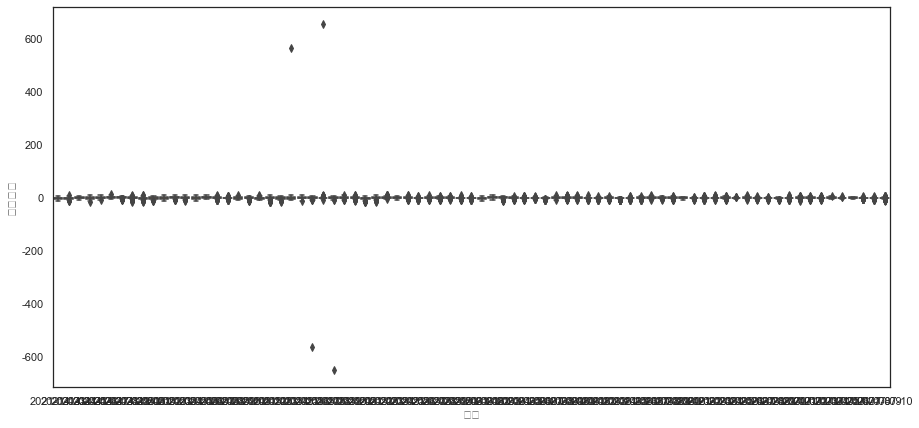

In [6]:
x = weather_.日期
y = weather_.明今温差
y1 = weather_.后今温差
y2 = weather_.当天high

plt.figure(figsize=(15,7))
sns.boxplot(x,y,data=weather_)
plt.show()

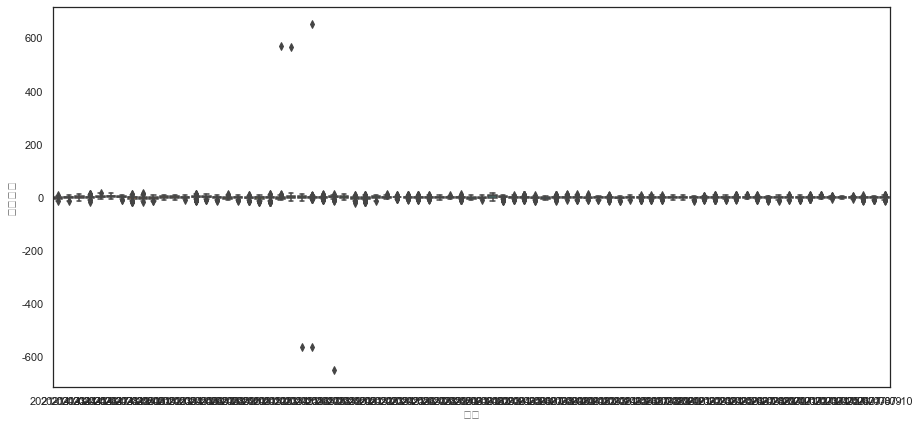

In [7]:
plt.figure(figsize=(15,7))
sns.boxplot(x,y1,data=weather_)
plt.show()

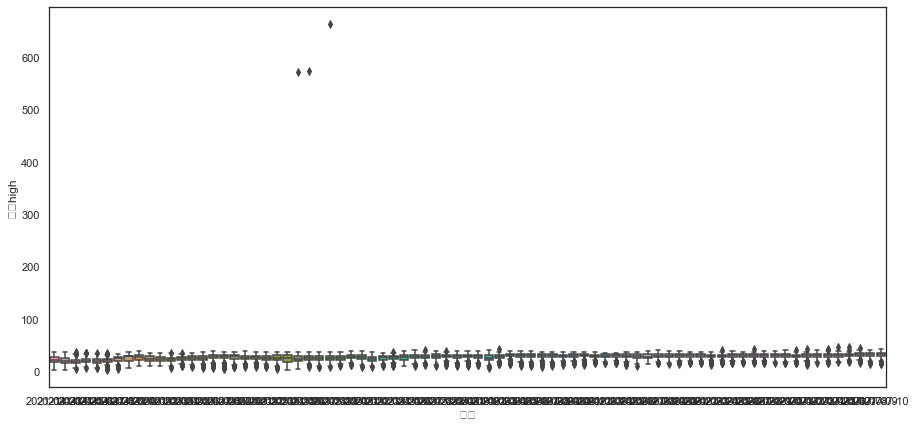

In [8]:
plt.figure(figsize=(15,7))
sns.boxplot(x,y2,data=weather_)
plt.show()

In [9]:
weather_ = weather_.query('明今温差<50&明今温差>-50&后今温差<50&后今温差>-50')#基于tableau的视图
weather_.describe()       #查看数据极值，确认异常值排除正确

,当天high,前天high,昨天high,后天high,明天high,当天low,前天Low,昨天Low,后天Low,明天Low,明今温差,后今温差
count,28670.000000,28670.000000,28670.000000,28670.000000,28670.000000,28670.000000,28670.000000,28670.000000,28670.000000,28670.000000,28670.000000,28670.000000
mean,27.774259,27.610638,27.706174,28.025881,27.889083,17.461493,17.235228,17.345274,17.715138,17.579630,0.114824,0.251622
std,5.721558,8.243898,7.578337,5.600427,5.677268,6.527908,6.543707,6.540038,6.480242,6.511491,3.060610,3.952016
min,3.000000,3.000000,3.000000,3.000000,3.000000,-13.000000,-13.000000,-13.000000,-13.000000,-13.000000,-16.000000,-20.000000
25%,24.000000,24.000000,24.000000,25.000000,24.000000,13.000000,13.000000,13.000000,14.000000,14.000000,-1.000000,-2.000000
50%,29.000000,28.000000,29.000000,29.000000,29.000000,18.000000,18.000000,18.000000,18.000000,18.000000,0.000000,0.000000
75%,32.000000,32.000000,32.000000,32.000000,32.000000,23.000000,23.000000,23.000000,23.000000,23.000000,2.000000,3.000000
max,47.000000,664.000000,664.000000,47.000000,47.000000,33.000000,33.000000,33.000000,33.000000,33.000000,15.000000,16.000000


## KMeans 

In [10]:
X = weather_[['明今温差','后今温差']].values  #设置自变量X
y = KMeans(n_clusters=3,random_state=1) #将因变量y的模型选择为KMeans，设置分为3类，默认不重新分配标签
y_pred = y.fit_predict(X)   #训练模型，将标签值返回到y_pred
y_pred = y_pred.reshape(len(X),1)   #将标签值由行转为列
weather_['天气标签'] = y_pred   #将标签值设置为天气标签字段

In [11]:
X    #参考KMeans算法原理，坐标

array([[1., 5.],
       [4., 5.],
       [1., 0.],
       ...,
       [2., 3.],
       [1., 3.],
       [2., 4.]])

In [12]:
y_pred

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

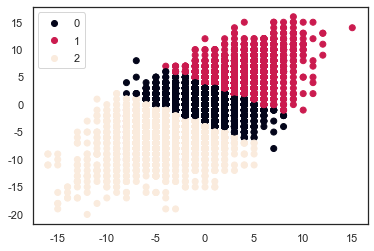

In [13]:
scatter = plt.scatter(X[:,0],X[:,1],c=y_pred) #行列分别为明今温差、后今温差，颜色为天气标签
plt.legend(*scatter.legend_elements()) #显示图例
plt.show()

# 逻辑回归

    先用聚类算法，再用回归算法根据分类结果进行二分类。

In [14]:
weather_['是否升温'] = '?'  #为逻辑回归准备好一列是否升温
weather_.loc[(weather_.天气标签==0)|(weather_.天气标签==2),'是否升温'] = '0' #给是否升温打上标签0
weather_.loc[(weather_.天气标签==1),'是否升温'] = '1' #是快速升温城市则为1

weather_x = weather_[['明今温差','后今温差']].values#设置逻辑函数自变量X
weather_y = weather_['是否升温'].values #设置逻辑函数因变量Y
x_train,x_test,y_train,y_test = train_test_split(weather_x,weather_y,train_size=0.8)#切分数据集80%为训练集，20%为测试集

w_model =LogisticRegression() #将模型设置为逻辑回归模型
w_model.fit(x_train,y_train) # 基于训练集训练模型
w_model.score(x_test,y_test)

1.0

In [15]:
weather_y

array(['1', '1', '0', ..., '1', '0', '1'], dtype=object)

# 函数部署

##  kmeans

In [60]:
def kmean(today,tmr,atmr):
    dic = {'今温':today,'明温':tmr,'后温':atmr}  #创建为一个字典
    wea = pd.DataFrame(dic)    #将字典转换为dataframe格式
    
    v1 = round(wea[~wea.isin(wea.query('今温>50|明温>50|后温>50'))]['今温'].mean())
    wea.loc[wea.今温>50,'今温'] = v1  # 将今天温度>50度的行，赋予平均值
    wea["今温"] = wea['今温'].fillna(v1)   #将今天温度=空值的行，赋予平均值
    
    v2 = round(wea[~wea.isin(wea.query('今温>50|明温>50|后温>50'))]['明温'].mean())
    wea.loc[wea.明温>50,'明温'] = v2
    wea['明温'] = wea['明温'].fillna(v2)
    
    v3 = round(wea[~wea.isin(wea.query('今温>50|明温>50|后温>50'))]['后温'].mean())
    wea.loc[wea.后温>50,'后温'] = v3
    wea['后温'] = wea['后温'].fillna(v3)
    
    diff1 = wea.明温-wea.今温
    diff2 = wea.后温-wea.今温
    
    diff_X = np.column_stack([diff1,diff2])  #将diff1与diff2作为列拼接在一起
    y_pred = y.fit_predict(diff_X)
    return y_pred.tolist()  #将y_pred的数据类型转换为列表，因为tableau只接受列表

In [51]:
kmean([19,25,27],
      [22,15,28],
      [25,26,29])

[2, 0, 1]

In [58]:
client.deploy(name = 'kmean',obj = kmean,override = True) #将kmean模型部署为别名为kmean的模型，原名与别名都可以使用
print('成功部署函数')

成功部署函数


## 天气判断（逻辑回归的y）

In [52]:
def judge(y_pred): #依据聚类结果转换为逻辑回归的判断
    list_ = []  #创建一个空列表
    for i in y_pred: #遍历y_pred中的每个值
        if i == 1: #如果值为0
            a = 1  #那么a = 1
        else:
            a = 0
        list_.append(a) #将a放进列表里
    return list_

In [53]:
client.deploy(name = 'judge',obj = judge,override = True)
print('成功部署函数')

成功部署函数


## 逻辑回归

In [54]:
def LR(x1,x2):
    X = np.column_stack([x1,x2]) #将x1,x2作为列拼接在一起
    return w_model.predict(X).tolist()

In [55]:
client.deploy(name = 'LR',obj = LR,override = True)
print('成功部署函数')

成功部署函数


## 特征自调逻辑回归

In [56]:
def my_pred(x1,x2):
    X = np.column_stack([x1,x2]) #将x1,x2作为列拼接在一起
    return w_model.predict(X).tolist()[0]

In [57]:
client.deploy(name = 'my_pred',obj = my_pred,override = True)
print('成功部署函数')

成功部署函数
